In [71]:
import numpy as np
from numpy import mean, std, dstack
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
import keras
from keras.utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GRU
from tensorflow.keras.layers import Dropout, BatchNormalization, Flatten, Add, Reshape
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import concatenate, Dropout
from tensorflow.keras import optimizers

import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [72]:
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = dstack(loaded)
    return loaded
 
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + 'HAR/')
    testX, testy = load_dataset_group('test', prefix + 'HAR/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [73]:
trainX, trainy, testX, testy = load_dataset('data/')

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [74]:
batch_size = 32
validation_split = 0.2

In [75]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=2, strides=2))  
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=3, strides=3))  
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(GRU(64, return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.3))

model.add(Dense(n_outputs, activation='softmax'))

In [76]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 127, 32)           608       
                                                                 
 conv1d_31 (Conv1D)          (None, 63, 64)            4160      
                                                                 
 batch_normalization_15 (Ba  (None, 63, 64)            256       
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 63, 64)            0         
                                                                 
 conv1d_32 (Conv1D)          (None, 61, 64)            12352     
                                                                 
 conv1d_33 (Conv1D)          (None, 20, 128)           24704     
                                                      

In [77]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [78]:
train_epochs = 50
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/50
184/184 [==============================] - 17s 48ms/step - loss: 0.3896 - accuracy: 0.8618 - val_loss: 1.6187 - val_accuracy: 0.5309
Epoch 2/50
184/184 [==============================] - 7s 36ms/step - loss: 0.1421 - accuracy: 0.9459 - val_loss: 0.2411 - val_accuracy: 0.9137
Epoch 3/50
184/184 [==============================] - 7s 36ms/step - loss: 0.1255 - accuracy: 0.9493 - val_loss: 0.2458 - val_accuracy: 0.9177
Epoch 4/50
184/184 [==============================] - 7s 41ms/step - loss: 0.1152 - accuracy: 0.9527 - val_loss: 0.3053 - val_accuracy: 0.9082
Epoch 5/50
184/184 [==============================] - 7s 39ms/step - loss: 0.1018 - accuracy: 0.9548 - val_loss: 0.2623 - val_accuracy: 0.9245
Epoch 6/50
184/184 [==============================] - 9s 48ms/step - loss: 0.0952 - accuracy: 0.9531 - val_loss: 0.2515 - val_accuracy: 0.9164
Epoch 7/50
184/184 [==============================] - 10s 56ms/step - loss: 0.1047 - accuracy: 0.9522 - val_loss: 0.2341 - val_accuracy: 0.91

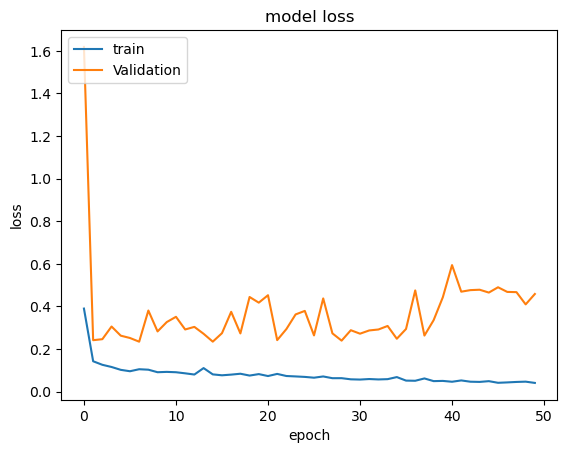

In [79]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [80]:
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the Sandbox model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the Sandbox model 0.9545300602912903
93/93 [==============================] - 3s 12ms/step


In [81]:
predictions

array([[3.3034391e-06, 1.5835456e-05, 1.1390556e-05, 4.2961386e-04,
        9.9953449e-01, 5.3307608e-06],
       [3.0508227e-06, 3.3669967e-06, 3.5657968e-06, 2.1541075e-04,
        9.9977273e-01, 1.8995088e-06],
       [2.9093196e-06, 2.8872410e-06, 3.1541597e-06, 2.0525313e-04,
        9.9978417e-01, 1.6834413e-06],
       ...,
       [6.1645555e-06, 9.9997711e-01, 4.7925205e-06, 4.9757255e-06,
        4.3696487e-06, 2.5892373e-06],
       [5.2746173e-06, 9.9997485e-01, 4.2805068e-06, 6.2692729e-06,
        6.7048591e-06, 2.6136288e-06],
       [2.3265097e-06, 9.9998319e-01, 3.6602457e-06, 4.5634461e-06,
        3.5626008e-06, 2.7093276e-06]], dtype=float32)

In [82]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[482   0  14   0   0   0]
 [  1 454  16   0   0   0]
 [  0   1 419   0   0   0]
 [  0   0   0 415  76   0]
 [  1   0   0  25 506   0]
 [  0   0   0   0   0 537]]
**** Classification Report ****
              precision    recall  f1-score   support

     Walking       1.00      0.97      0.98       496
      Walkup       1.00      0.96      0.98       471
    Walkdown       0.93      1.00      0.96       420
     Sitting       0.94      0.85      0.89       491
    Standing       0.87      0.95      0.91       532
      Laying       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.96      0.95      0.95      2947
weighted avg       0.96      0.95      0.95      2947



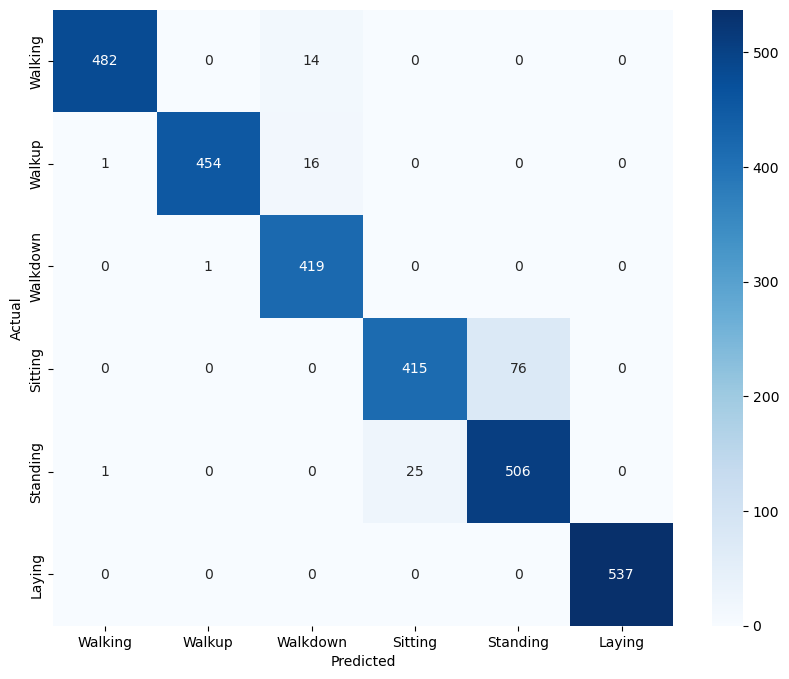

In [83]:
classNames=["Walking","Walkup","Walkdown","Sitting","Standing","Laying"]
display_results(testy,predictions,classNames)